In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
model = Net().to(device)
model.load_state_dict(torch.load("lenet_mnist_model.pth", map_location="cpu"))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=False,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(),]),
    ),
    batch_size=1,
    shuffle=True,
)

100.1%

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


113.5%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


0.0%4%

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


180.4%c:\Users\dianu\anaconda3\envs\subtorch\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


Epsilon: 0.05, Accuracy: 0.943
Epsilon: 0.1, Accuracy: 0.851
Epsilon: 0.15, Accuracy: 0.683
Epsilon: 0.2, Accuracy: 0.430
Epsilon: 0.25, Accuracy: 0.208
Epsilon: 0.3, Accuracy: 0.087


C:\Users\dianu\AppData\Local\Temp\ipykernel_1756\1260336783.py:60: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


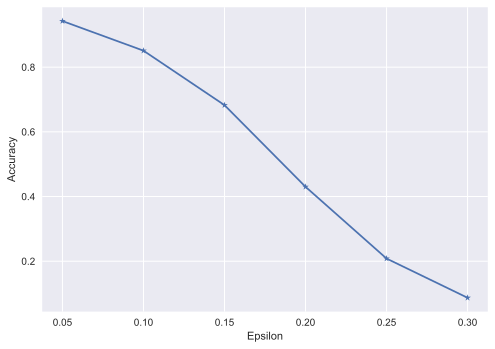

In [14]:
def fgsm_attack(image, epsilon):
    perturbed_image = image + epsilon * image.grad.data.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image



def test(model, test_loader, epsilon, device, num_display=5):
    
    num_correct = 0
    adv_examples = []
    
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        output = model(image)
        _, init_pred = output.max(dim=1)

        if init_pred.item() != label.item():
            continue

        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm_attack(image, epsilon)
        perturbed_output = model(perturbed_image)
        _, perturbed_pred = perturbed_output.max(dim=1)

        if perturbed_pred.item() == label.item():
            num_correct += 1
        elif len(adv_examples) < num_display:
            adv_examples.append(
                (
                    label.item(), 
                    perturbed_pred.item(), 
                    perturbed_image.squeeze().detach().cpu().numpy()
                )
            )
    
    accuracy = num_correct / len(test_loader)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.3f}")
    
    return accuracy, adv_examples


num_display = 5
accuracies = []
all_adv_examples = []
epsilons = [.05, .1, .15, .2, .25, .3]

for epsilon in epsilons:
    accuracy, adv_examples = test(model, test_loader, epsilon, device, num_display)
    accuracies.append(accuracy)
    all_adv_examples.append(adv_examples)


plt.style.use("seaborn")
plt.plot(epsilons, accuracies, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Epsilon: 0.05, Accuracy: 0.979
Epsilon: 0.1, Accuracy: 0.977
Epsilon: 0.15, Accuracy: 0.974
Epsilon: 0.2, Accuracy: 0.970
Epsilon: 0.25, Accuracy: 0.968
Epsilon: 0.3, Accuracy: 0.966


C:\Users\dianu\AppData\Local\Temp\ipykernel_1756\2172000194.py:60: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


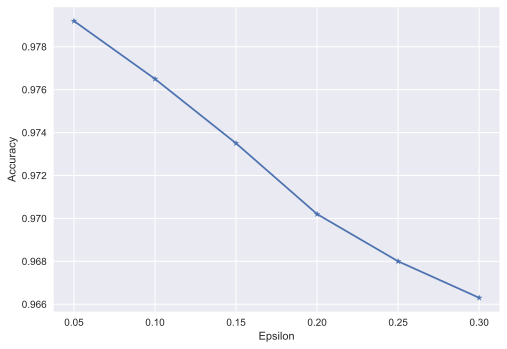

In [15]:
def fgsm_attack(image, epsilon):
    perturbed_image = image + epsilon * image.grad.data.tanh()
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image



def test(model, test_loader, epsilon, device, num_display=5):
    
    num_correct = 0
    adv_examples = []
    
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        output = model(image)
        _, init_pred = output.max(dim=1)

        if init_pred.item() != label.item():
            continue

        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm_attack(image, epsilon)
        perturbed_output = model(perturbed_image)
        _, perturbed_pred = perturbed_output.max(dim=1)

        if perturbed_pred.item() == label.item():
            num_correct += 1
        elif len(adv_examples) < num_display:
            adv_examples.append(
                (
                    label.item(), 
                    perturbed_pred.item(), 
                    perturbed_image.squeeze().detach().cpu().numpy()
                )
            )
    
    accuracy = num_correct / len(test_loader)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.3f}")
    
    return accuracy, adv_examples


num_display = 5
accuracies = []
all_adv_examples = []
epsilons = [.05, .1, .15, .2, .25, .3]

for epsilon in epsilons:
    accuracy, adv_examples = test(model, test_loader, epsilon, device, num_display)
    accuracies.append(accuracy)
    all_adv_examples.append(adv_examples)


plt.style.use("seaborn")
plt.plot(epsilons, accuracies, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Epsilon: 0.05, Accuracy: 0.979
Epsilon: 0.1, Accuracy: 0.977
Epsilon: 0.15, Accuracy: 0.973
Epsilon: 0.2, Accuracy: 0.970
Epsilon: 0.25, Accuracy: 0.968
Epsilon: 0.3, Accuracy: 0.966


C:\Users\dianu\AppData\Local\Temp\ipykernel_1756\2813550634.py:60: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


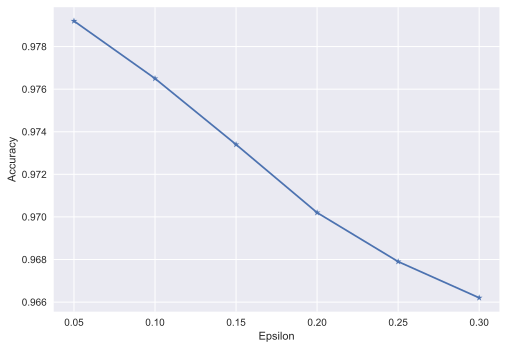

In [16]:
def fgsm_attack(image, epsilon):
    perturbed_image = image + epsilon * image.grad.data
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image



def test(model, test_loader, epsilon, device, num_display=5):
    
    num_correct = 0
    adv_examples = []
    
    for image, label in test_loader:
        image = image.to(device)
        label = label.to(device)
        image.requires_grad = True

        output = model(image)
        _, init_pred = output.max(dim=1)

        if init_pred.item() != label.item():
            continue

        loss = F.nll_loss(output, label)
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm_attack(image, epsilon)
        perturbed_output = model(perturbed_image)
        _, perturbed_pred = perturbed_output.max(dim=1)

        if perturbed_pred.item() == label.item():
            num_correct += 1
        elif len(adv_examples) < num_display:
            adv_examples.append(
                (
                    label.item(), 
                    perturbed_pred.item(), 
                    perturbed_image.squeeze().detach().cpu().numpy()
                )
            )
    
    accuracy = num_correct / len(test_loader)
    print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.3f}")
    
    return accuracy, adv_examples


num_display = 5
accuracies = []
all_adv_examples = []
epsilons = [.05, .1, .15, .2, .25, .3]

for epsilon in epsilons:
    accuracy, adv_examples = test(model, test_loader, epsilon, device, num_display)
    accuracies.append(accuracy)
    all_adv_examples.append(adv_examples)


plt.style.use("seaborn")
plt.plot(epsilons, accuracies, "*-")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

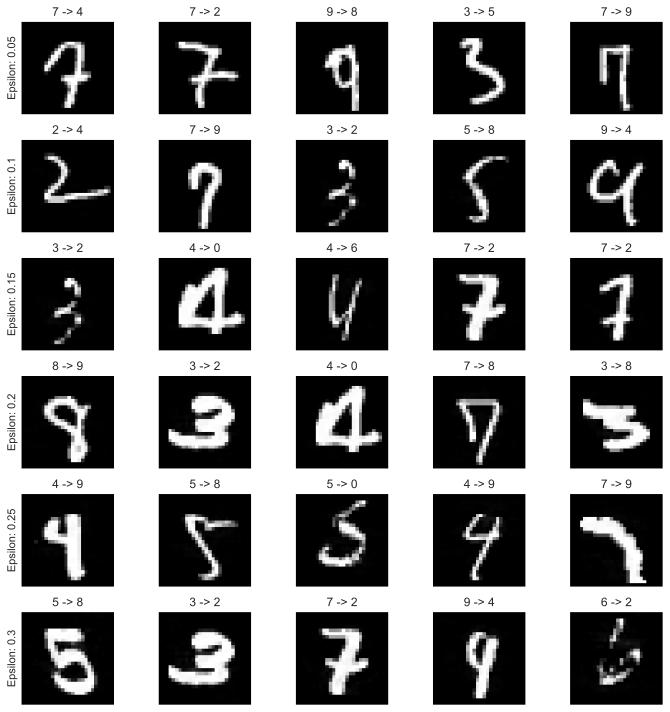

In [23]:
def clean_axis(axis):
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    
nrows = len(epsilons)
ncols = num_display

fig, ax = plt.subplots(6, 5, figsize=(10, 10))

for row in range(nrows):
    for col in range(ncols):
        label, perturbed_pred, perturbed_image = all_adv_examples[row][col]
        axis = ax[row, col]
        axis.imshow(perturbed_image, cmap="gray")
        axis.set_title(f"{label} -> {perturbed_pred}")
        clean_axis(axis)
        if col == 0:
            axis.set_ylabel(f"Epsilon: {epsilons[row]}")
plt.tight_layout()
plt.show()